In [12]:
import matplotlib.pyplot as plt
import numpy as np
import math


from scipy.signal import find_peaks
from scipy.integrate import odeint
from scipy.stats import gaussian_kde


In [13]:
# Set random seed (for reproducibility)
np.random.seed(1000)

# Start and end time (in milliseconds)
tmin = 0.0
tmax = 1000.0

# Average potassium channel conductance per unit area (mS/cm^2)
gK = 36.0

# Average sodoum channel conductance per unit area (mS/cm^2)
gNa = 120.0

# Average leak channel conductance per unit area (mS/cm^2)
gL = 0.3

# Membrane capacitance per unit area (uF/cm^2)
Cm = 1.0

# Potassium potential (mV)
VK = -12.0

# Sodium potential (mV)
VNa = 115.0

# Leak potential (mV)
Vl = 10.613

# Time values
T = np.linspace(tmin, tmax, 10000)

# Potassium ion-channel rate functions

def alpha_n(Vm):
    return (0.01 * (10.0 - Vm)) / (np.exp(1.0 - (0.1 * Vm)) - 1.0)

def beta_n(Vm):
    return 0.125 * np.exp(-Vm / 80.0)

# Sodium ion-channel rate functions

def alpha_m(Vm):
    return (0.1 * (25.0 - Vm)) / (np.exp(2.5 - (0.1 * Vm)) - 1.0)

def beta_m(Vm):
    return 4.0 * np.exp(-Vm / 18.0)

def alpha_h(Vm):
    return 0.07 * np.exp(-Vm / 20.0)

def beta_h(Vm):
    return 1.0 / (np.exp(3.0 - (0.1 * Vm)) + 1.0)
  
# n, m, and h steady-state values

def n_inf(Vm=0.0):
    return alpha_n(Vm) / (alpha_n(Vm) + beta_n(Vm))

def m_inf(Vm=0.0):
    return alpha_m(Vm) / (alpha_m(Vm) + beta_m(Vm))

def h_inf(Vm=0.0):
    return alpha_h(Vm) / (alpha_h(Vm) + beta_h(Vm))

In [14]:
def id(n):
    return 5

In [15]:
# Compute derivatives
def compute_derivatives(y, T):
    dy = np.zeros((4,))
    
    Vm = y[0]
    n = y[1]
    m = y[2]
    h = y[3]
    
    # dVm/dt
    GK = (gK / Cm) * np.power(n, 4.0)
    GNa = (gNa / Cm) * np.power(m, 3.0) * h
    GL = gL / Cm
    
    dy[0] = (id(T) / Cm) - (GK * (Vm - VK)) - (GNa * (Vm - VNa)) - (GL * (Vm - Vl))
    
    # dn/dt
    dy[1] = (alpha_n(Vm) * (1.0 - n)) - (beta_n(Vm) * n)
    
    # dm/dt
    dy[2] = (alpha_m(Vm) * (1.0 - m)) - (beta_m(Vm) * m)
    
    # dh/dt
    dy[3] = (alpha_h(Vm) * (1.0 - h)) - (beta_h(Vm) * h)
    
    return dy
  
# State (Vm, n, m, h)
Y = np.array([0.0, n_inf(), m_inf(), h_inf()])


# Solve ODE system
# Vy = (Vm[t0:tmax], n[t0:tmax], m[t0:tmax], h[t0:tmax])


In [16]:
def Vy1(listv):
    Vm_list = []
    for i in Vy:
        Vm_list.append(i[0])

    return Vm_list

In [17]:
def ISI(nx):
    list_nx = []
    for i in range(1,len(nx)):
        list_nx.append(nx[i]-nx[i-1])
    
    return list_nx

In [18]:
I_input = np.linspace(5,200,196)

#For Activation Function
peaklist = []

#For heights of "peaks"
ny_list = []

#For height data regardless of peak or not. Takes all heights
ny_distribution = []

#distribution of peak heights per _
list25 = []
list50 = []
list75 = []
list100 = []
list125 = []
list150 = []
list175 = []
list200 = []
ISI_list = [list25, list50, list75, list100, list125, list150, list175, list200]


In [19]:
for i in I_input:
    def id(t):
        return i
    Vy = odeint(compute_derivatives, Y, T)
    listV = Vy1(Vy)

    #For dataset of making KDE of distribution of datapoints
    ny_distribution = ny_distribution + listV
    #print(ny_distribution)

    #For computing the peaks
    peak_data = find_peaks(listV)[0]
    peaklist.append(len(peak_data))
    #print(listV)
    #print(listV[j] for j in peak_data)
    #ny_list.append(listV[j] for j in peak_data)
    for j in peak_data:
        ny = listV[j]
        ny_list.append(listV[j])

    
    #peak_data = peak_data.tolist()
    if i%25 == 0:
        run = i/25
        ISI_list[int(run)-1] = ISI(peak_data)
    

<function matplotlib.pyplot.tight_layout(*, pad: 'float' = 1.08, h_pad: 'float | None' = None, w_pad: 'float | None' = None, rect: 'tuple[float, float, float, float] | None' = None) -> 'None'>

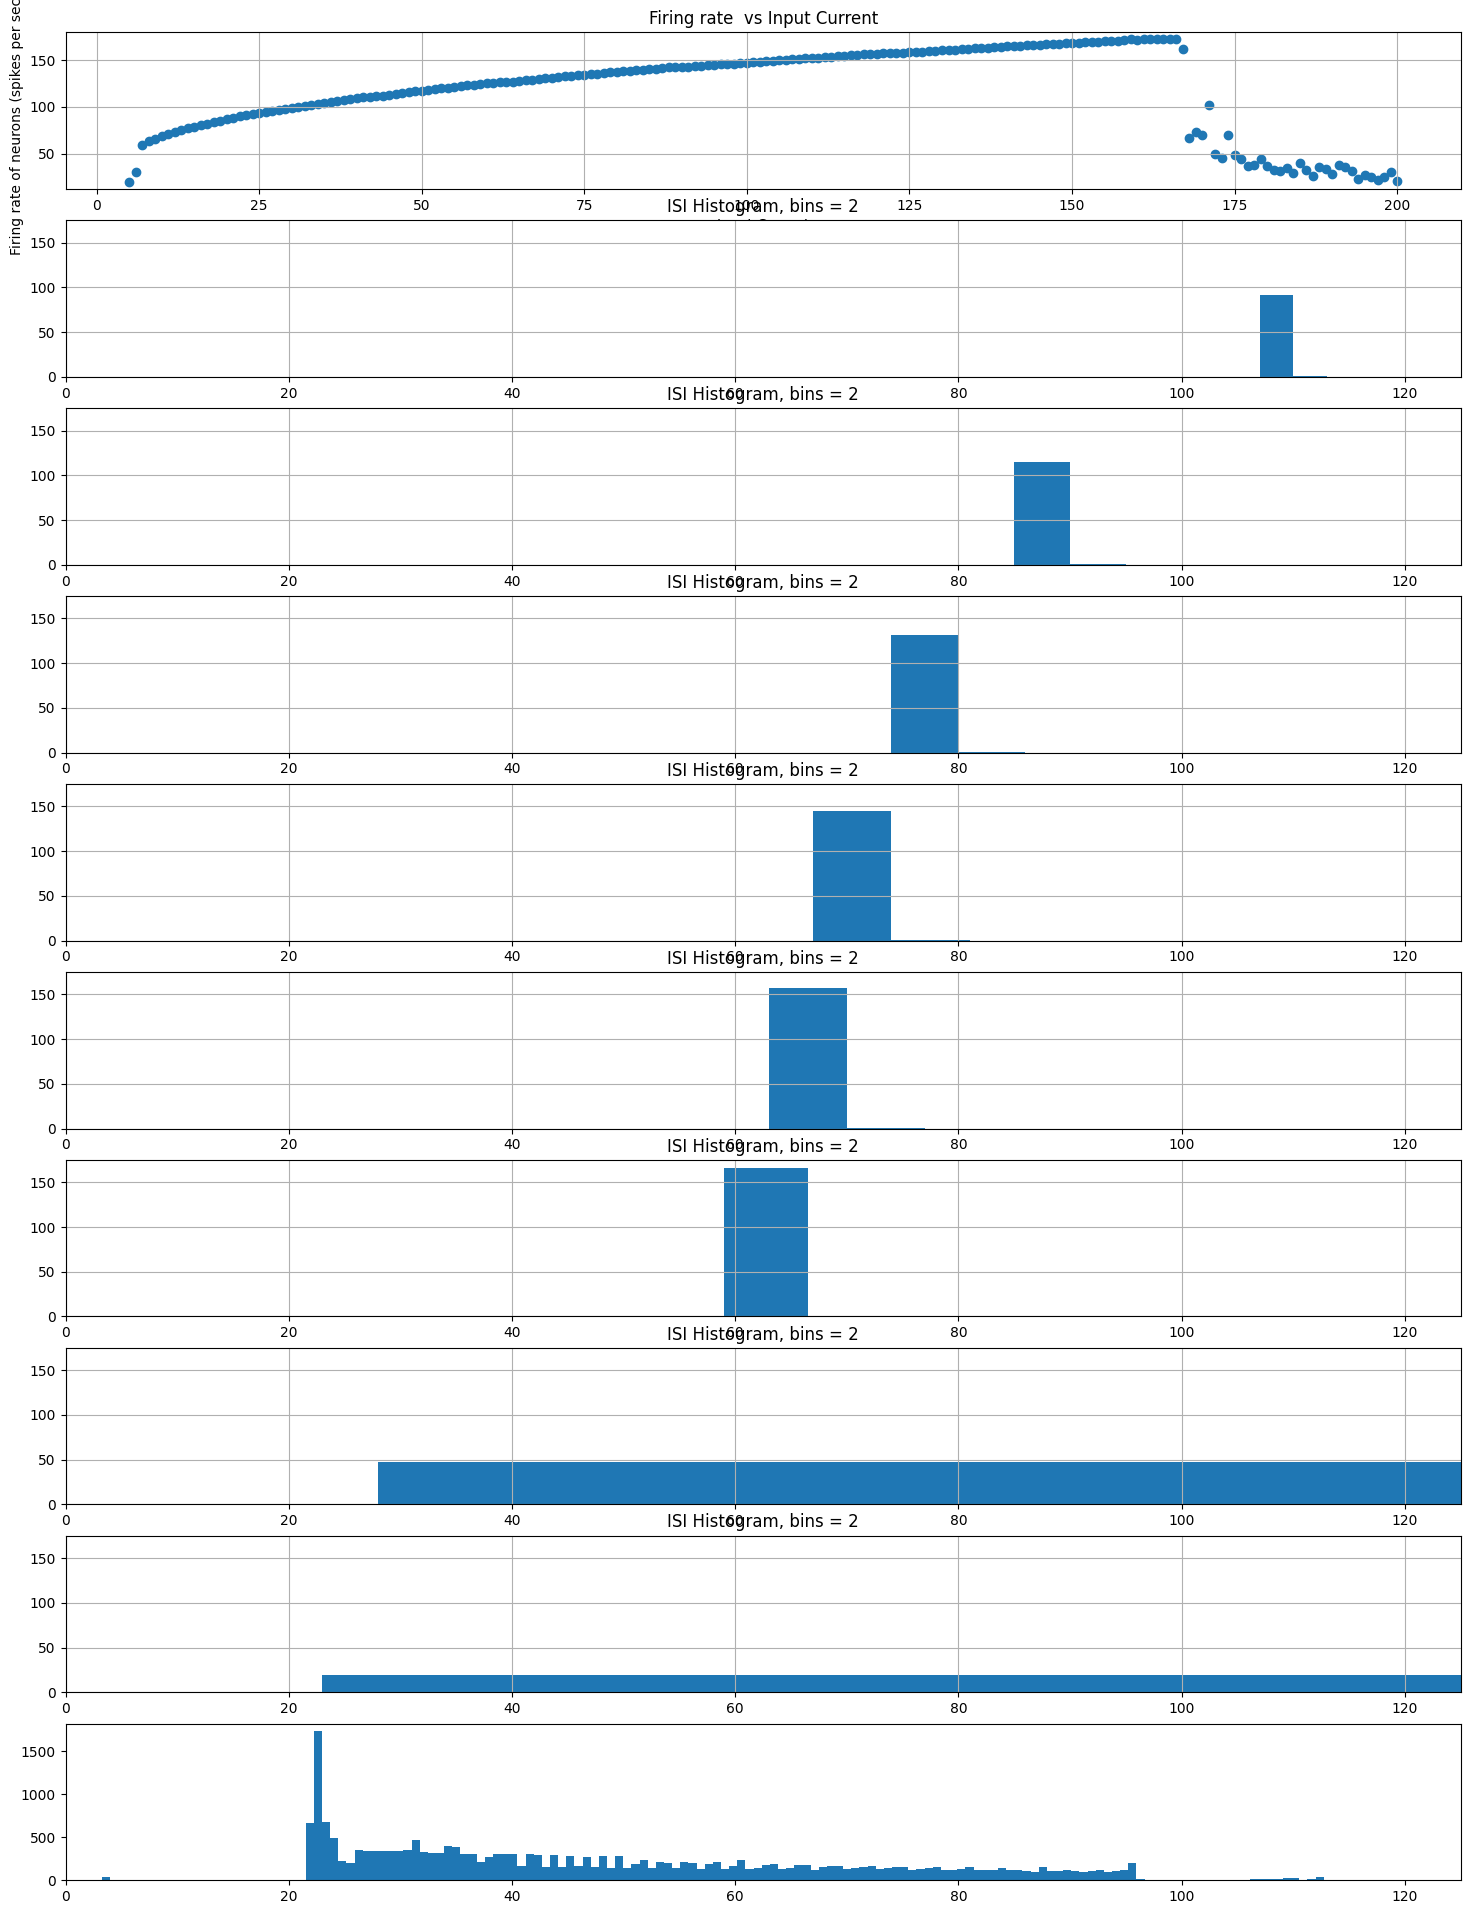

In [20]:
# Neuron potential
fig, axs = plt.subplots(10,1,figsize=(18, 24))
axs[0].scatter(I_input, peaklist)
axs[0].set_xlabel('Input Current')
axs[0].set_ylabel('Firing rate of neurons (spikes per second)')
axs[0].set_title('Firing rate  vs Input Current')
axs[0].grid(True)

for i in range(8):
    bin_num = math.floor(np.sqrt(len(ISI_list)))
    axs[i+1].hist(ISI_list[i], bins= bin_num )
    axs[i+1].set_ylim(0,175)
    axs[i+1].set_xlim(0,125)
    axs[i+1].grid(True)
    axs[i+1].set_title(f'ISI Histogram, bins = {bin_num}')
    axs[i+1].grid(True)

bin_num = math.floor(np.sqrt(len(ny_list)))
axs[9].hist(ny_list, bins=bin_num)
axs[9].set_xlim(0,125)

plt.tight_layout

In [21]:
#Peaks
kde1 = gaussian_kde(ny_list)
x_vals1 = np.linspace(min(ny_list), max(ny_list), 1000)
pdf_vals1 = kde1(x_vals1)

#Distribution of datapoints
kde2 = gaussian_kde(ny_distribution)
x_vals2 = np.linspace(min(ny_list), max(ny_list), 1000)
pdf_vals2 = kde2(x_vals2)

Crit Value: 26.21073426811032


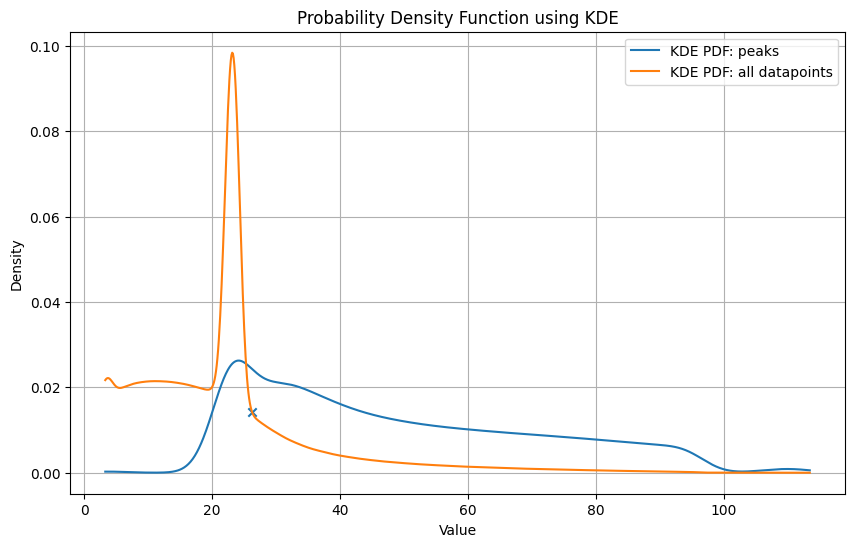

In [24]:
insx = [np.abs(pdf_vals1[i]-pdf_vals2[i]) for i in range(len(pdf_vals1)-500)]
#print(insx.index(min(insx)))
#print(len(pdf_vals1))

ci1 = 208
insx_x = [x_vals2[ci1]]
insx_y = [pdf_vals2[ci1]]

print(f'Crit Value: {x_vals2[ci1]}')
crit1 = x_vals2[ci1]

plt.figure(figsize=(10, 6))
plt.plot(x_vals1, pdf_vals1, label='KDE PDF: peaks')
plt.plot(x_vals2, pdf_vals2, label = 'KDE PDF: all datapoints')
plt.scatter(insx_x, insx_y, marker = 'x')
plt.title('Probability Density Function using KDE')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()